In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import json
import ast
import pickle
import calendar
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse.linalg import svds
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#paths
beauty_path = "/content/drive/MyDrive/amazon_product_recommendation_system/Dataset/All_Beauty.json"
#meta data
beautyMetaPath = "/content/drive/MyDrive/amazon_product_recommendation_system/Dataset/meta_All_Beauty.json"

 Data Loading

In [ ]:
#---- Reading BeautyReview data
BeautyReview = pd.read_json(beauty_path, lines=True)
BeautyReview.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


In [ ]:
BeautyReview.shape

(371345, 12)

In [ ]:
BeautyReview.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

In [ ]:
BeautyReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         371345 non-null  int64 
 1   verified        371345 non-null  bool  
 2   reviewTime      371345 non-null  object
 3   reviewerID      371345 non-null  object
 4   asin            371345 non-null  object
 5   reviewerName    371307 non-null  object
 6   reviewText      370946 non-null  object
 7   summary         371139 non-null  object
 8   unixReviewTime  371345 non-null  int64 
 9   vote            51899 non-null   object
 10  style           125958 non-null  object
 11  image           8391 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 31.5+ MB


In [ ]:
#removing empty space from reviewtext
BeautyReview = BeautyReview[BeautyReview['reviewText'].notnull()]
BeautyReview = BeautyReview[BeautyReview['reviewText'] != '']

In [ ]:
#filtering reviewtext based on lenght of text
BeautyReview['lenghtofreviewText'] = BeautyReview['reviewText'].apply(lambda x : len(x) )
BeautyReview = BeautyReview[BeautyReview['lenghtofreviewText'] >= 10]

In [ ]:
#---- Reading BeautyProduct data
BeautyProduct = pd.read_json(beautyMetaPath, lines=True)
BeautyProduct.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
BeautyProduct.shape

(32892, 19)

In [ ]:
BeautyProduct.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat',
       'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes'],
      dtype='object')

In [ ]:
#removing unnecessary columns
BeautyProduct = BeautyProduct[['asin','main_cat','description','title','brand','price','also_buy','imageURL','rank']]
BeautyProduct.head()

,asin,main_cat,description,title,brand,price,also_buy,imageURL,rank
0,6546546450,All Beauty,[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,idea village,,[],[],"2,938,573 in Beauty & Personal Care ("
1,7178680776,All Beauty,[No7 Lift & Luminate Triple Action Serum 50ml ...,No7 Lift &amp; Luminate Triple Action Serum 50...,,$44.99,"[B01E7LCSL6, B008X5RVME]",[],"872,854 in Beauty & Personal Care ("
2,7250468162,All Beauty,[No7 Stay Perfect Foundation now stays perfect...,No7 Stay Perfect Foundation Cool Vanilla by No7,No7,$28.76,[],[],"956,696 in Beauty & Personal Care ("
3,7367905066,All Beauty,[],Wella Koleston Perfect Hair Colour 44/44 Mediu...,,,[B0041PBXX8],[https://images-na.ssl-images-amazon.com/image...,"1,870,258 in Beauty & Personal Care ("
4,7414204790,All Beauty,[Lacto Calamine Skin Balance Daily Nourishing ...,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,$12.15,[],[https://images-na.ssl-images-amazon.com/image...,"67,701 in Beauty & Personal Care ("


In [ ]:
BeautyProduct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32892 entries, 0 to 32891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   asin         32892 non-null  object
 1   main_cat     32892 non-null  object
 2   description  32892 non-null  object
 3   title        32892 non-null  object
 4   brand        32892 non-null  object
 5   price        32892 non-null  object
 6   also_buy     32892 non-null  object
 7   imageURL     32892 non-null  object
 8   rank         32892 non-null  object
dtypes: object(9)
memory usage: 2.3+ MB


In [ ]:
BeautyProduct['asin'].duplicated().sum()

404

In [ ]:
BeautyProduct.drop_duplicates('asin',inplace=True)

In [ ]:
BeautyProduct['price'] = BeautyProduct['price'].replace(".a-box-inner{background-color:#fff}#alohaBuyBoxWidget .selected{background-color:#fffbf3;border-color:#e77600;box-shadow:0 0 3px rgba(228,121,17,.5)}#alohaBuyBoxWidget .contract-not-available{color:gray}#aloha-cart-popover .aloha-cart{height:auto;overflow:hidden}#aloha-cart-popover #aloha-cartInfo{float:left}#aloha-cart-popover #aloha-cart-details{float:right;margin-top:1em}#aloha-cart-popover .deviceContainer{width:160px;float:left;padding-right:10px;border-right:1px solid #ddd}#aloha-cart-popover li:last-child{border-right:0}#aloha-cart-popover .aloha-device-title{height:3em;overflow:hidden}#aloha-cart-popover .aloha-thumbnail-container{height:100px;margin-bottom:1em;text-align:center}#aloha-cart-popover .aloha-price-container{text-align:center}#aloha-cart-popover .aloha-thumbnail-container img{height:inherit}#aloha-cart-popover .aloha-cart{border-top:1px solid #ddd;border-bottom:1px solid #ddd}#aloha-cart-popover #aloha-cart-info{margin-right:0}#alohaBuyBoxWidget .without-contract-subheading{margin-right:0}#aloha-bb-help-nodes .aloha-bb-contract-term-heading{color:gray;font-family:arial;margin-top:.5em;text-align:center;height:.7em;border-bottom:1px solid gray;margin-bottom:1.6em}#aloha-bb-help-nodes .aloha-bb-contract-term-heading span{background-color:#fff;padding:0 10px 0 10px}#alohaAvailabilityUS_feature_div .availability a{text-decoration:none}#alohaPricingWidget a{text-decoration:none}#alohaAvailabilityUS_feature_div .availability{margin-top:-4px;margin-bottom:0}#alohaBuyBoxWidget .select-transaction-alert .a-icon-alert{top:18px;left:3px}#alohaBuyBoxWidget .select-transaction-alert .a-alert-container{padding-left:39px;width:290px}#alohaBuyBoxUS_feature_div #alohaBuyBoxWidget .contract-container .contract-term-heading a{text-decoration:none}#alohaBuyBoxUS_feature_div #alohaBuyBoxWidget .annual-contract-box .a-icon-popover{display:none}#alohaBuyBoxUS_feature_div #alohaBuyBoxWidget .contract-container .annual-contract-box{cursor:pointer;cursor:hand}#alohaBuyBoxUS_feature_div #alohaBuyBoxWidget .aloha-buybox-price{font-size:15px}#alohaBuyBoxUS_feature_div #alohaBuyBoxWidget #linkOffSection a{text-decoration:none}#alohaBuyBoxUS_feature_div .lockedUsedBuyboxContainer{padding-left:3.5%}#alohaBuyBoxUS_feature_div .alohaBuyboxUtilsNoWrap{white-space:nowrap}.hidden{display:none}.simo-no-padding{padding:0}.carrier-reviews-cell{padding-left:10px}.carrier-reviews-bordered-cell{border:1px dotted #ccc}.carrier-reviews-selected-cell{background-color:#ffd}#aloha-carrier-compatibility-modal-table-description{margin-top:10px;margin-bottom:14px}.aloha-carrier-compatibility-sortable-header.carrier{min-width:97px}.aloha-carrier-compatibility-sortable-header.compatibility{min-width:156px}.aloha-carrier-compatibility-sortable-header div{float:left}.aloha-carrier-compatibility-sortable-header i.a-icon{margin-left:10px;margin-top:4px}#aloha-carrier-compatibility-overview-table.a-bordered.a-vertical-stripes td:nth-child(2n),#aloha-carrier-compatibility-overview-table.a-bordered.a-vertical-stripes th:nth-child(2n){background-color:initial}#aloha-carrier-compatibility-modal-table.a-bordered.a-vertical-stripes td:nth-child(2n),#aloha-carrier-compatibility-modal-table.a-bordered.a-vertical-stripes th:nth-child(2n){background-color:initial}#aloha-carrier-compatibility-table.a-bordered.a-vertical-stripes th:nth-child(2n),.aloha-carrier-compatibility-table.a-bordered.a-vertical-stripes td:nth-child(2n){background-color:transparent}.aloha-carrier-compatibility-column-gray{background-color:#f6f6f6}.aloha-carrier-compatibility-modal-table-row .aloha-carrier-compatibility-tech-text,.aloha-carrier-compatibility-modal-table-row .carrier-name,.aloha-carrier-compatibility-modal-table-row .carrier-rating-summary{min-height:27px;display:inline-block;cursor:default}.aloha-carrier-compatibility-modal-table-row .aloha-carrier-compatibility-tech-text:first-line,.aloha-carrier-compatibility-modal-table-row .carrier-name:first-line,.aloha-carrier-compatibility-modal-table-row .carrier-rating-summary:first-line{line-height:27px}.aloha-carrier-compatibility-modal-table-row .aloha-carrier-compatibility-icon{margin-top:6px}.aloha-carrier-compatibility-check-icon{width:30px;height:27px;background-position:-318px -35px;background-image:url(https://images-na.ssl-images-amazon.com/images/G/01/AUIClients/AmazonUIBaseCSS-sprite_2x-8e7ef370dc28a214b3f490c9620f4ac501d5a864._V2_.png);background-repeat:no-repeat;background-size:400px 650px;display:inline-block;vertical-align:top}.aloha-carrier-compatibility-hidden{display:none}.aloha-buybox-spaced-link{margin-top:12px;margin-bottom:7px;text-align:center}.popover-tab","not defined")

Data Cleaning

In [ ]:
#checking number of rating on each product count
num_rating_df = BeautyReview.groupby('asin').count()['reviewerID'].reset_index()
num_rating_df.rename(columns={'reviewerID':'num_ratings'},inplace=True)
num_rating_df.head()

,asin,num_ratings
0,0061073717,2
1,0143026860,14
2,014789302X,18
3,0571348351,3
4,0692508988,1


In [ ]:
#on BeautyProduct data filtering
num_rating_df = num_rating_df[num_rating_df['num_ratings']>=150].sort_values('num_ratings',ascending=False)
BeautyProduct = BeautyProduct.loc[BeautyProduct.asin.isin(num_rating_df['asin'].tolist())].reset_index(drop=True)
BeautyProduct.head()

,asin,main_cat,description,title,brand,price,also_buy,imageURL,rank
0,B000050FDY,All Beauty,"[With Braun Clean & Renew refills, you can kee...",Braun Clean &amp; Renew Refill Cartridges CCR ...,Braun,$11.94,[],[https://images-na.ssl-images-amazon.com/image...,"1,028 in Beauty & Personal Care ("
1,B0000530HU,All Beauty,[INDICATIONS: Aqua Velva Cooling After Shave E...,"Aqua Velva After Shave, Classic Ice Blue, 7 Ounce",Aqua Velva,,"[B00J232PCM, B0010V5MKG, B000052Y68, B00KOAIU7...",[https://images-na.ssl-images-amazon.com/image...,"65,003 in Beauty & Personal Care ("
2,B00005JS5C,All Beauty,"[Perfect for sensitive skin types, this bikini...",Panasonic Bikini Shaper and Trimmer for Women ...,Panasonic,$18.49,[],[https://images-na.ssl-images-amazon.com/image...,457 in Beauty & Personal Care (
3,B000068PBJ,All Beauty,"[James Bond's razor of choice, this rechargeab...",Norelco 8894 XL Spectra shaver Limited Edition...,Norelco,,[],[https://images-na.ssl-images-amazon.com/image...,"2,141,609 in Beauty & Personal Care ("
4,B00006L9LC,All Beauty,[<P><STRONG>Restores Moisture to Dehydrated Ha...,Citre Shine Moisture Burst Shampoo - 16 fl oz,Citre Shine,$23.00,"[B07CSVCGZV, B07KMGC13Z, B0793XJ4WW, B01N7U1HB...",[],"1,693,702 in Beauty & Personal Care ("


In [ ]:
BeautyProduct.shape

(324, 9)

In [ ]:
#on BeautyReview data filtering
BeautyReview = BeautyReview.loc[BeautyReview.asin.isin(BeautyProduct['asin'].tolist())].reset_index(drop=True)
BeautyReview.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,lenghtofreviewText
0,3,False,"02 22, 2004",A1O0UZWSZPRNLJ,B000050FDY,J. Garrett,It is indeed a great razor as others have ment...,Great Shaver...Rip OFF for Refills,1077408000,16,{'Size:': ' 2 Count'},NaN,554
1,4,False,"12 11, 2003",A1W0PMHGAB4N5B,B000050FDY,Amazon Customer,"As some other reviewers have suggested, this i...",Great Shaver - Pricey Refills,1071100800,3,{'Size:': ' 2 Count'},NaN,643
2,5,False,"11 30, 2003",A1M0VEHPQMUXW7,B000050FDY,John S. Brofka,I've been buying the two cartridge refill set ...,Retails for $19.99? Where and since when?,1070150400,17,{'Size:': ' 2 Count'},NaN,160
3,4,False,"09 2, 2003",A2KLWYHJ26O2Z9,B000050FDY,Michael,Over my lifetime I have had several other bran...,Reuse cleanimg cartridges and my thoughts on t...,1062460800,100,{'Size:': ' 2 Count'},NaN,3936
4,5,False,"05 22, 2003",A2NSHFYO38WRIM,B000050FDY,Mandeep Janda,I find the braun shaver I bought to be quite g...,Keep it lasting longer,1053561600,8,{'Size:': ' 2 Count'},NaN,307


In [ ]:
BeautyReview.shape

(146282, 13)

In [ ]:
BeautyReview['asin'].nunique()

324

Data Visualization

In [ ]:
BeautyReview['year'] = pd.DatetimeIndex(BeautyReview['reviewTime']).year
BeautyReview['month'] = pd.DatetimeIndex(BeautyReview['reviewTime']).month

In [ ]:
#areachart
tempdf = BeautyReview[['year']].groupby(['year']).value_counts()
tempdf = tempdf.reset_index()
tempdf.columns = ['year','count']
fig = px.area(tempdf, x='year', y='count',title='Year Wise Review Count')
fig.show()

In [ ]:
#barplot
tempdf = BeautyReview[['month']].groupby(['month']).value_counts()
tempdf = tempdf.reset_index()
tempdf.columns = ['month','count']
fig = px.bar(tempdf, x='month', y='count',color='count',title='Month Wise Review Count')
fig.show()

In [ ]:
#piechart
tempdf = BeautyReview[['overall']].groupby(['overall']).value_counts()
tempdf = tempdf.reset_index()
tempdf.columns = ['overall','count']
fig = px.pie(tempdf, values='count', names='overall', title='Overall Rating Count')
fig.show()

In [ ]:
tempdf = pd.DataFrame()
tempdf['len_of_text'] = BeautyReview['reviewText'].apply(lambda x: len(str(x)))
tempdf = tempdf[tempdf['len_of_text'] <= 2000]
fig = px.histogram(tempdf,color_discrete_sequence=['indianred'])
fig.show()

In [ ]:
fig = px.box(BeautyProduct, x="price", points="all", color_discrete_sequence=['yellowgreen'])
fig.show()

In [ ]:
#scatterplot
tempdf = BeautyReview[['reviewerID']].groupby(['reviewerID']).value_counts().reset_index().sort_values(0,ascending=False).head(10)
tempdf.columns = ['reviewerID','count']
fig = px.scatter(tempdf, x='reviewerID', y='count',size='count',color='count',title='Top 10 Reviewer Count(no of review given by reviewer)')
fig.show()

In [ ]:
#areachart
tempdf = BeautyReview[['reviewerID']].groupby(['reviewerID']).value_counts().reset_index()
tempdf.columns = ['reviewerID','count']
tempdf = tempdf.groupby(['count']).count().reset_index()
tempdf.columns = ['noofreview','usercount']
tempdf = tempdf.sort_values('usercount',ascending=False)
fig = px.area(tempdf, x='noofreview', y='usercount', color_discrete_sequence=['orange'],title='Reviews Written by each user')
fig.show()

Sentiment Analysis

In [ ]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
  text = text.lower()
  text = text.split()
  tmp = []

  for word in text:
    if word in contractions:
      tmp.append(contractions[word])
    else:
      tmp.append(word)

    text = ' '.join(tmp)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
      text = text.split()
      stops = set(stopwords.words('english'))
      text = [w for w in text if w not in stops]
      text = ' '.join(text)

  return text


In [ ]:
cleaned_text = []
for i in range(BeautyReview.shape[0]):
  cleaned_text.append(clean_text(BeautyReview['reviewText'][i], remove_stopwords=False))
BeautyReview['cleanedreviewText'] = cleaned_text

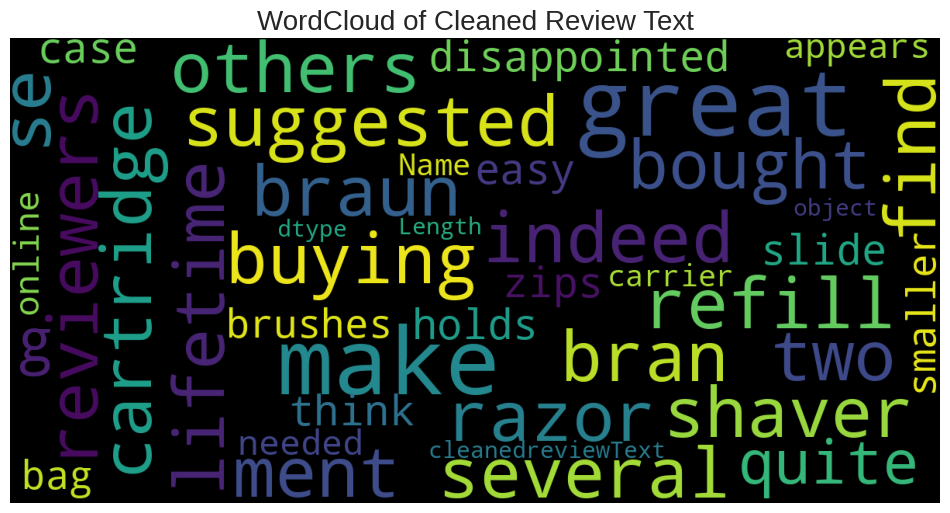

In [ ]:
#wordcloud plot
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
  wordcloud = WordCloud(background_color='black', stopwords=stopwords, max_words=200, max_font_size=40, scale=3, random_state=1).generate(str(data))
  fig = plt.figure(1, figsize=(12, 10))
  plt.axis('off')
  if title:
    #fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
  plt.title(title,fontsize=20)
  plt.imshow(wordcloud)
  plt.show()

show_wordcloud(BeautyReview['cleanedreviewText'], title="WordCloud of Cleaned Review Text")

In [ ]:
# VADER sentiment analysis tool for getting pos, neg and neu.
def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [ ]:
"""senti_score = []
cleaned_reviews = BeautyReview['cleanedreviewText'].tolist()
for i in range(len(cleaned_reviews)):
  print(i)
  senti_score.append(sentimental_Score(cleaned_reviews[i]))
BeautyReview['Sentiment'] = senti_score"""

Streaming output truncated to the last 5000 lines.
141282
141283
141284
141285
141286
141287
141288
141289
141290
141291
141292
141293
141294
141295
141296
141297
141298
141299
141300
141301
141302
141303
141304
141305
141306
141307
141308
141309
141310
141311
141312
141313
141314
141315
141316
141317
141318
141319
141320
141321
141322
141323
141324
141325
141326
141327
141328
141329
141330
141331
141332
141333
141334
141335
141336
141337
141338
141339
141340
141341
141342
141343
141344
141345
141346
141347
141348
141349
141350
141351
141352
141353
141354
141355
141356
141357
141358
141359
141360
141361
141362
141363
141364
141365
141366
141367
141368
141369
141370
141371
141372
141373
141374
141375
141376
141377
141378
141379
141380
141381
141382
141383
141384
141385
141386
141387
141388
141389
141390
141391
141392
141393
141394
141395
141396
141397
141398
141399
141400
141401
141402
141403
141404
141405
141406
141407
141408
141409
141410
141411
141412
141413
141414
141415
141416
1414

In [ ]:
#BeautyReview.to_csv('/content/drive/My Drive/amazon_product_recommendation_system/BeautyReview_Cleaned.csv',index=False)

In [ ]:
BeautyReview = pd.read_csv('/content/drive/My Drive/amazon_product_recommendation_system/BeautyReview_Cleaned.csv')
BeautyReview.head(4)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,lenghtofreviewText,year,month,cleanedreviewText,Sentiment
0,3,False,"02 22, 2004",A1O0UZWSZPRNLJ,B000050FDY,J. Garrett,It is indeed a great razor as others have ment...,Great Shaver...Rip OFF for Refills,1077408000,16,{'Size:': ' 2 Count'},NaN,554,2004,2,it is indeed a great razor as others have ment...,Positive
1,4,False,"12 11, 2003",A1W0PMHGAB4N5B,B000050FDY,Amazon Customer,"As some other reviewers have suggested, this i...",Great Shaver - Pricey Refills,1071100800,3,{'Size:': ' 2 Count'},NaN,643,2003,12,as some other reviewers have suggested this i...,Positive
2,5,False,"11 30, 2003",A1M0VEHPQMUXW7,B000050FDY,John S. Brofka,I've been buying the two cartridge refill set ...,Retails for $19.99? Where and since when?,1070150400,17,{'Size:': ' 2 Count'},NaN,160,2003,11,i have been buying the two cartridge refill se...,Neutral
3,4,False,"09 2, 2003",A2KLWYHJ26O2Z9,B000050FDY,Michael,Over my lifetime I have had several other bran...,Reuse cleanimg cartridges and my thoughts on t...,1062460800,100,{'Size:': ' 2 Count'},NaN,3936,2003,9,over my lifetime i have had several other bran...,Positive


In [ ]:
BeautyReview.shape

(146282, 17)

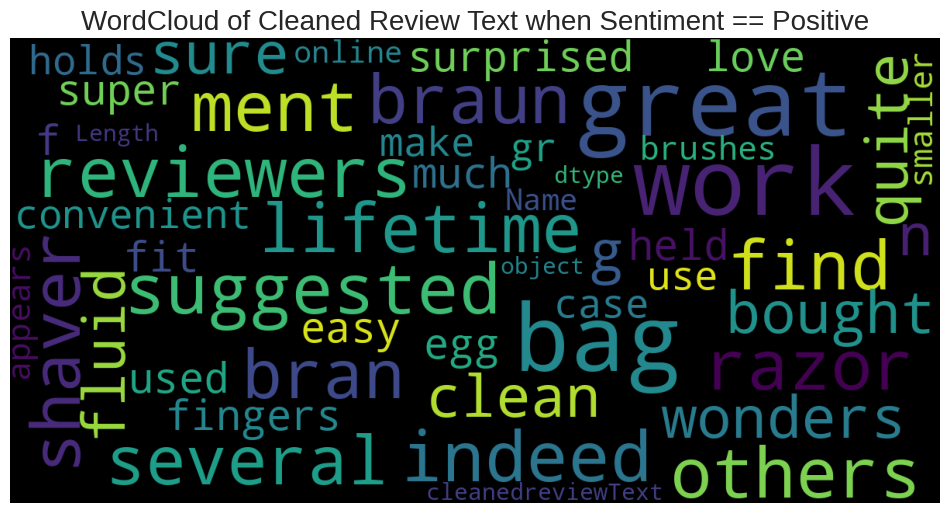

In [ ]:
postive_text = BeautyReview[BeautyReview['Sentiment']=="Positive"]['cleanedreviewText']
show_wordcloud(postive_text, title="WordCloud of Cleaned Review Text when Sentiment == Positive")

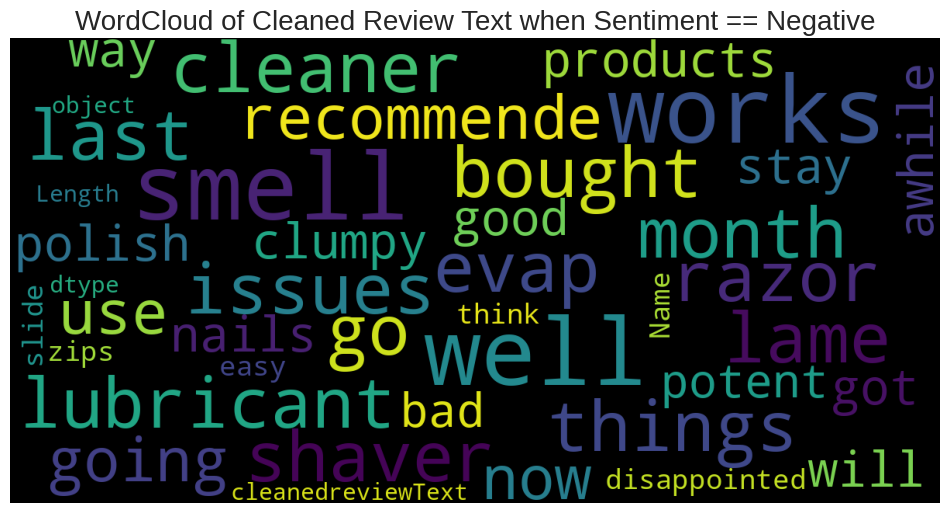

In [ ]:
postive_text = BeautyReview[BeautyReview['Sentiment']=="Negative"]['cleanedreviewText']
show_wordcloud(postive_text, title="WordCloud of Cleaned Review Text when Sentiment == Negative")

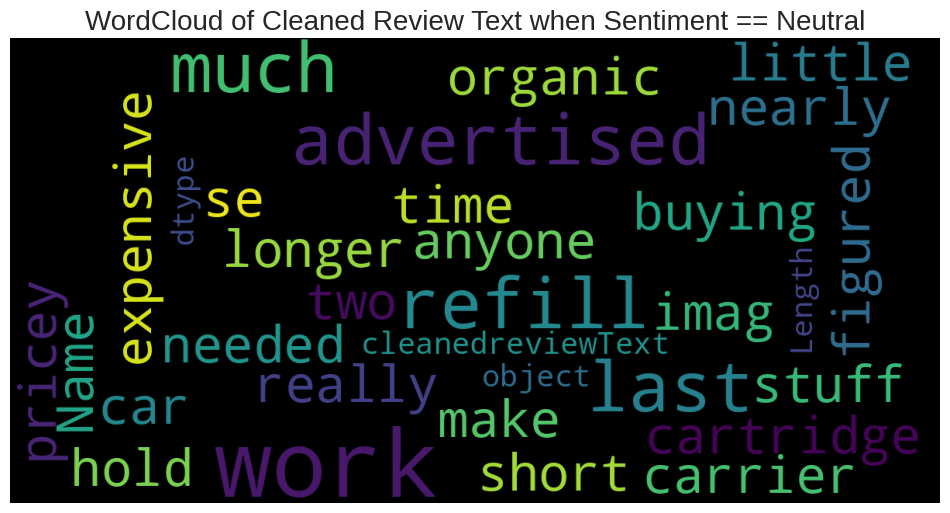

In [ ]:
postive_text = BeautyReview[BeautyReview['Sentiment']=="Neutral"]['cleanedreviewText']
show_wordcloud(postive_text, title="WordCloud of Cleaned Review Text when Sentiment == Neutral")

In [ ]:
#piechart
tempdf = BeautyReview[['Sentiment']].groupby(['Sentiment']).value_counts()
tempdf = tempdf.reset_index()
tempdf.columns = ['Sentiment','count']
fig = px.pie(tempdf, values='count', names='Sentiment', hole=0.5,title='Sentiment Value Count')
fig.show()

In [ ]:
#text preprocessing (tfidf vectorizer)
clean_text = BeautyReview['cleanedreviewText'].values.astype('U').tolist()
tfidf_vect = TfidfVectorizer(ngram_range=(1,5),stop_words='english', max_features=300)
tfidf_vect.fit(clean_text)
titleFeatures= tfidf_vect.transform(clean_text).toarray()
labels= BeautyReview['Sentiment'].tolist()

In [ ]:
pickle.dump(tfidf_vect,open('/content/drive/MyDrive/amazon_product_recommendation_system/Models/tfidf_vect.pkl', 'wb'))

In [ ]:
#data splitting
X_train, X_test, y_train, y_test = train_test_split(titleFeatures, labels, test_size=0.3)

**Machine Learning Model (Text Classification)**

**AdaBoost Classifier**

In [ ]:
#AdaBoost Classifier
model = AdaBoostClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print ("AdaBoost Classifier Train Accuracy : ", round(model.score(X_train,y_train)*100,2))
print ("AdaBoost Classifier Test Accuracy : ", round(accuracy_score(y_test,y_pred)*100,2))

AdaBoost Classifier Train Accuracy :  82.66
AdaBoost Classifier Test Accuracy :  82.37


In [ ]:
#confusion matrix
matrix =confusion_matrix(y_test,y_pred)
fig = px.imshow(matrix,
                labels=dict(color="Productivity"),
                x=['Negative', 'Neutral', 'Positive'],
                y=['Negative', 'Neutral', 'Positive'],
                text_auto=True
               )
fig.update_xaxes(side="top")
fig.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.52      0.20      0.29      4908
     Neutral       0.65      0.12      0.21      3407
    Positive       0.84      0.98      0.90     35570

    accuracy                           0.82     43885
   macro avg       0.67      0.43      0.47     43885
weighted avg       0.79      0.82      0.78     43885



**RandomForest Classifier**

In [ ]:
#RandomForest Classifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print ("RandomForest Classifier Train Accuracy : ", round(model.score(X_train,y_train)*100,2))
print ("RandomForest Classifier Test Accuracy : ", round(accuracy_score(y_test,y_pred)*100,2))

RandomForest Classifier Train Accuracy :  97.22
RandomForest Classifier Test Accuracy :  86.64


In [ ]:
#confusion matrix
matrix =confusion_matrix(y_test,y_pred)
fig = px.imshow(matrix,
                labels=dict(color="Productivity"),
                x=['Negative', 'Neutral', 'Positive'],
                y=['Negative', 'Neutral', 'Positive'],
                text_auto=True
               )
fig.update_xaxes(side="top")
fig.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.69      0.34      0.45      4908
     Neutral       0.61      0.60      0.60      3407
    Positive       0.90      0.97      0.93     35570

    accuracy                           0.87     43885
   macro avg       0.73      0.63      0.66     43885
weighted avg       0.85      0.87      0.85     43885



In [ ]:
pickle.dump(model,open('/content/drive/MyDrive/amazon_product_recommendation_system/Models/rf_model.pkl', 'wb'))

**Recommendation System**

In [ ]:
recommend_df = BeautyReview[['reviewerID',	'asin','overall']]
recommend_df.head()

,reviewerID,asin,overall
0,A1O0UZWSZPRNLJ,B000050FDY,3
1,A1W0PMHGAB4N5B,B000050FDY,4
2,A1M0VEHPQMUXW7,B000050FDY,5
3,A2KLWYHJ26O2Z9,B000050FDY,4
4,A2NSHFYO38WRIM,B000050FDY,5


In [ ]:
#No of unique customers and products
print("Unique Customers: ",recommend_df.reviewerID.nunique())
print("Unique Products: ",recommend_df.asin.nunique())

Unique Customers:  121955
Unique Products:  324


**Popularity Based Recommender System**

In [ ]:
#Filling products which are not rated zero and taking pivot to categorize each user with product they rated
final_ratings_matrix = pd.pivot_table(recommend_df,index='reviewerID',columns='asin',values = 'overall').fillna(0)
final_ratings_matrix

asin,B000050FDY,B0000530HU,B00005JS5C,B000068PBJ,B00006L9LC,B00009RB0X,B00009RB1C,B00011QUDE,B000142ZFS,B000146LKS,...,B01DGWYQCG,B01DKQAXC0,B01DLR9IDI,B01E7UKR38,B01EGH00J8,B01FLJROJ4,B01FNJ9MOW,B01FTP9LNC,B01FWP41H0,B01GLA54SA
reviewerID,,,,,,,,,,,,,,,,,,,,,
A001170867ZBE9FORRQL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0028738FYF1SKPPC7B1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A006277084SDH2LTUV6X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00827299BWJTEFNVKP0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0096681Y127OL1H8W3U,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZMTAJ61KGGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZOGZ93PYIKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZQKE13BD5HE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Checking the density of rated products. User provided ratings to very less products or we can also say they didint bought
#those products
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  138913
possible_num_of_ratings =  39513420
density: 0.35%


In [ ]:
product_popularity = final_ratings_matrix.sum(axis=0)
popular_products = product_popularity.sort_values(ascending=False)

In [ ]:
#filtering top 50 popular product
popular_df = popular_products.head(50)
popular_df = popular_df.reset_index()
popular_df.columns = ['asin', 'product_rating']

In [ ]:
#top 50 popular product
popular_df = popular_df.merge(BeautyProduct,on='asin').drop_duplicates('asin')[['asin','title','description','brand','price','imageURL','product_rating']]
popular_df.head(50)

,asin,title,description,brand,price,imageURL,product_rating
0,B000FOI48G,Waterpik Ultra Water Flosser,[Premium dental water jet with dramatically im...,Waterpik,,[https://images-na.ssl-images-amazon.com/image...,37110.500
1,B000GLRREU,Waterpik Ultra Water Flosser,[Premium dental water jet with dramatically im...,Waterpik,,[https://images-na.ssl-images-amazon.com/image...,35852.000
2,B001QY8QXM,Astra Platinum Double Edge Safety Razor Blades...,[ASTRA stainless double edge blades fit all do...,Astra,$9.30,[https://images-na.ssl-images-amazon.com/image...,19987.000
3,B01DKQAXC0,Bali Secrets Natural Deodorant - Organic &amp;...,[],,,[https://images-na.ssl-images-amazon.com/image...,17639.500
4,B006IB5T4W,"Aquaphor Healing Ointment,Advanced Therapy Ski...","[Trusted by dermatologists, pediatricians and ...",Aquaphor,$11.29,[https://images-na.ssl-images-amazon.com/image...,12299.500
5,B00W259T7G,Pre de Provence Artisanal French Soap Bar Enri...,"[For centuries, the luxury of French-milled so...",Pre de Provence,$4.99,[https://images-na.ssl-images-amazon.com/image...,11336.625
6,B00005JS5C,Panasonic Bikini Shaper and Trimmer for Women ...,"[Perfect for sensitive skin types, this bikini...",Panasonic,$18.49,[https://images-na.ssl-images-amazon.com/image...,8932.000
7,B00VF344X0,Italia Deluxe Ultra Fine Lip Liner set (Pack O...,[===&Gt;Seller: Dum Beauty&Lt;===Customize Col...,Italia-Deluxe,$6.82,[https://images-na.ssl-images-amazon.com/image...,8113.000
8,B00BMVV3MK,"Style Edit Root Concealer 2 oz, Medium Brown",[STYLE EDIT by Style Edit CONCEAL YOUR GRAYS-M...,Style Edit,$16.99,[https://images-na.ssl-images-amazon.com/image...,7252.500
9,B0067F28ZW,Eyelash Growth Serum - 100% Natural Eyelash Ey...,[Color:Gold<br>Big eyes and long eyelashes are...,Fiery Youth,,[https://images-na.ssl-images-amazon.com/image...,6610.000


In [ ]:
pickle.dump(popular_df,open('/content/drive/MyDrive/amazon_product_recommendation_system/Models/popular_df.pkl','wb'))

**Collaborative Filtering Based Recommender System(SVD)**

In [ ]:
recommend_df = BeautyReview[['reviewerID',	'asin','overall']]
final_ratings_matrix = pd.pivot_table(recommend_df,index='reviewerID',columns='asin',values = 'overall').fillna(0)
final_ratings_matrix

asin,B000050FDY,B0000530HU,B00005JS5C,B000068PBJ,B00006L9LC,B00009RB0X,B00009RB1C,B00011QUDE,B000142ZFS,B000146LKS,...,B01DGWYQCG,B01DKQAXC0,B01DLR9IDI,B01E7UKR38,B01EGH00J8,B01FLJROJ4,B01FNJ9MOW,B01FTP9LNC,B01FWP41H0,B01GLA54SA
reviewerID,,,,,,,,,,,,,,,,,,,,,
A001170867ZBE9FORRQL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0028738FYF1SKPPC7B1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A006277084SDH2LTUV6X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00827299BWJTEFNVKP0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0096681Y127OL1H8W3U,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZMTAJ61KGGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZOGZ93PYIKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZQKE13BD5HE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Singular Value Decomposition
U, sigma, Vt = svds(final_ratings_matrix.to_numpy(), k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [ ]:
final_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Predicted ratings
final_preds_df = pd.DataFrame(final_predicted_ratings, columns = final_ratings_matrix.columns)
final_preds_df.head()

asin,B000050FDY,B0000530HU,B00005JS5C,B000068PBJ,B00006L9LC,B00009RB0X,B00009RB1C,B00011QUDE,B000142ZFS,B000146LKS,...,B01DGWYQCG,B01DKQAXC0,B01DLR9IDI,B01E7UKR38,B01EGH00J8,B01FLJROJ4,B01FNJ9MOW,B01FTP9LNC,B01FWP41H0,B01GLA54SA
0,5.961762e-06,2.171054e-08,1.246459e-05,9.075689e-09,-0.000004,4.886375e-10,1.224922e-08,1.785900e-08,1.033294e-06,5.365171e-09,...,2.620065e-09,1.777335e-06,1.046324e-06,1.673953e-07,3.375134e-09,1.454717e-10,1.136385e-08,1.214844e-08,1.008015e-06,-5.336360e-10
1,8.754756e-08,-2.555357e-09,5.370140e-07,2.092444e-11,-0.000004,3.302995e-11,7.749972e-08,9.230371e-08,1.441520e-10,-4.581361e-11,...,6.542768e-11,1.921236e-07,3.476990e-08,9.456352e-08,-3.808821e-11,3.315577e-12,1.670745e-10,7.421661e-09,4.643179e-10,3.377141e-08
2,-3.179818e-05,-1.667557e-05,-4.210674e-05,-2.284165e-06,0.000032,-3.258599e-08,-8.176315e-06,1.834972e-03,-4.892958e-06,-3.342323e-06,...,-1.670160e-07,4.999936e+00,-1.163503e-06,-1.153948e-04,-2.815891e-06,-2.735233e-09,-4.935379e-06,-2.828947e-06,-1.841217e-07,-2.186305e-06
3,-5.083134e-08,1.298132e-09,-1.665454e-06,-5.185879e-10,-0.000624,-2.735152e-11,-5.341486e-09,7.530752e-07,-1.440726e-09,-2.248442e-09,...,-2.507570e-09,1.611290e-03,-4.112440e-09,-1.330104e-07,-2.744059e-09,3.486813e-11,-3.991966e-09,-1.965829e-09,2.167319e-09,-1.366194e-09
4,3.459185e-04,1.265694e-05,1.063929e-02,1.442248e-07,0.000009,2.949641e-09,4.126582e-07,1.750795e-06,7.631946e-06,1.153981e-07,...,1.182290e-06,-3.179818e-05,6.209838e-06,1.803382e-05,6.897968e-08,3.908483e-09,7.116561e-06,3.149787e-05,5.896565e-06,1.608277e-06


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(reviewer_ID, final_ratings_matrix, preds_df, num_recommendations):

    userID = np.where(final_ratings_matrix.index == reviewer_ID)[0][0]
    user_idx = userID

    # Get and sort the user's ratings
    sorted_user_ratings = final_ratings_matrix.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings','user_predictions']
    possitive=[]
    negative=[]
    netural=[]
    #temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(reviewer_ID = {}):\n'.format(reviewer_ID))
    temp = temp[['user_predictions']]
    for i in range(num_recommendations):
      prod = temp.index[i]
      df = BeautyReview[BeautyReview.asin == str(prod)]
      review = []
      review = df['cleanedreviewText'].tolist()
      tfidf_vect = TfidfVectorizer(ngram_range=(1,5),stop_words='english', max_features=300)
      tfidf_vect.fit(review)
      titleFeatures= tfidf_vect.transform(review).toarray()
      labels= df['Sentiment'].tolist()
      pred = model.predict(titleFeatures)
      pred = pred.tolist()
      #print(pred)
      possitive.append(pred.count('Positive'))
      negative.append(pred.count('Negative'))
      netural.append(pred.count('Neutral'))
    temp = temp.head(num_recommendations)
    temp['Possitive Reviews'] = possitive
    temp['Negative Reviews'] = negative
    temp['Neutral Reviews'] = netural

    temp = temp.reset_index()
    temp.columns = ['asin','recomend_score','positive_review','negative_review','neutral_reviews']
    temp = temp.merge(BeautyProduct,on='asin').drop_duplicates('asin')[['asin','title','description','brand','price','recomend_score','positive_review','negative_review','neutral_reviews']]

    print(temp.head(num_recommendations))

In [ ]:
#Enter 'userID' and 'num_recommendations' for the user #
reviewer_ID = "AZZMTAJ61KGGA"
num_recommendations = 5
recommend_items(reviewer_ID, final_ratings_matrix, final_preds_df, num_recommendations)


Below are the recommended items for user(reviewer_ID = AZZMTAJ61KGGA):

         asin                                              title  \
0  B000FOI48G                       Waterpik Ultra Water Flosser   
1  B000GLRREU                       Waterpik Ultra Water Flosser   
2  B00G5L867C  Philips Sonicare Sonic Electric Rechargeable T...   
3  B0010ZBORW  Urban Spa Moisturizing Booties to Keep your Fe...   
4  B001F51RBU            Oral-B Glide Threader Floss (Pack of 4)   

                                         description             brand  \
0  [Premium dental water jet with dramatically im...          Waterpik   
1  [Premium dental water jet with dramatically im...          Waterpik   
2  [Philips Sonicare for Kids Rechargeable Electr...  Philips Sonicare   
3  [Considering that the average person walks ove...         Urban Spa   
4  [<P><STRONG>Experience The Comfort &amp; Conve...            Oral-B   

    price  recomend_score  positive_review  negative_review  neutral_revi

In [ ]:
#performance evaluation
rmse_df = pd.concat([final_ratings_matrix.mean(), final_preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(324, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
asin,,,
B000050FDY,0.053093,0.001145,0
B0000530HU,0.011254,0.000409,1
B00005JS5C,0.073240,0.074285,2
B000068PBJ,0.005592,0.000048,3
B00006L9LC,0.026862,0.023786,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01286 



In [ ]:
pickle.dump(final_ratings_matrix,open('/content/drive/MyDrive/amazon_product_recommendation_system/Models/final_ratings_matrix.pkl','wb'))
pickle.dump(final_preds_df,open('/content/drive/MyDrive/amazon_product_recommendation_system/Models/final_preds_df.pkl','wb'))
pickle.dump(BeautyReview,open('/content/drive/MyDrive/amazon_product_recommendation_system/Models/BeautyReview.pkl','wb'))
pickle.dump(BeautyProduct,open('/content/drive/MyDrive/amazon_product_recommendation_system/Models/BeautyProduct.pkl','wb'))